In [13]:
# Dependencies
import matplotlib.pyplot as plt
%matplotlib inline

import os
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


In [2]:
print("TRAINING------")
for emotion in os.listdir('train/'):
    print(str(len(os.listdir('train/' + emotion))) + ': ' + emotion + ' imgs')

print("TEST------")
for emotion in os.listdir('test/'):
    print(str(len(os.listdir('test/' + emotion))) + ': ' + emotion + ' imgs')

TRAINING------
7215: happy imgs
4831: sad imgs
4097: fear imgs
3171: surprise imgs
4965: neutral imgs
3995: angry imgs
436: disgust imgs
TEST------
1774: happy imgs
1247: sad imgs
1024: fear imgs
831: surprise imgs
1233: neutral imgs
958: angry imgs
111: disgust imgs


In [4]:
# Set image and batch size
image_size = (224,224)
batch_size = 100

# Define the directories for training and testing data
train_data = 'train/'
test_data = 'test/'

# Create the image generator for normilization
train_data_gen = ImageDataGenerator(horizontal_flip=True)
test_data_gen = ImageDataGenerator(horizontal_flip=True)

# Generate the batches of training and test data
train_generator = train_data_gen.flow_from_directory(
    train_data,
    target_size = image_size,
    batch_size = batch_size,
    color_mode = 'grayscale',
    class_mode = 'categorical'
)

test_generator = test_data_gen.flow_from_directory(
    test_data,
    target_size = image_size,
    batch_size = batch_size,
    color_mode = 'grayscale',
    class_mode = 'categorical'
)



Found 31880 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [5]:
# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224,224, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [6]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [7]:
# Train the model
model.fit(train_generator,
          steps_per_epoch=train_generator.samples // batch_size,
          epochs=10,
          validation_data=test_generator,
          validation_steps=test_generator.samples // batch_size)

Epoch 1/10
318/318 [==============================] - 1704s 5s/step - loss: 4.5988 - accuracy: 0.8459 - val_loss: 0.4168 - val_accuracy: 0.8571
Epoch 2/10
318/318 [==============================] - 1675s 5s/step - loss: 0.4192 - accuracy: 0.8571 - val_loss: 0.4218 - val_accuracy: 0.8571
Epoch 3/10
318/318 [==============================] - 1765s 6s/step - loss: 0.4153 - accuracy: 0.8571 - val_loss: 0.4143 - val_accuracy: 0.8571
Epoch 4/10
318/318 [==============================] - 1692s 5s/step - loss: 0.4137 - accuracy: 0.8571 - val_loss: 0.4138 - val_accuracy: 0.8571
Epoch 5/10
318/318 [==============================] - 1690s 5s/step - loss: 0.4130 - accuracy: 0.8571 - val_loss: 0.4129 - val_accuracy: 0.8571
Epoch 6/10
318/318 [==============================] - 1660s 5s/step - loss: 0.4123 - accuracy: 0.8571 - val_loss: 0.4123 - val_accuracy: 0.8571
Epoch 7/10
318/318 [==============================] - 1729s 5s/step - loss: 0.4121 - accuracy: 0.8571 - val_loss: 0.4127 - val_accuracy:

In [8]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy: {accuracy}')

71/71 [==============================] - 107s 1s/step - loss: 0.4112 - accuracy: 0.8571
Test accuracy: 0.857143223285675


1/1 [==============================] - 0s 113ms/step


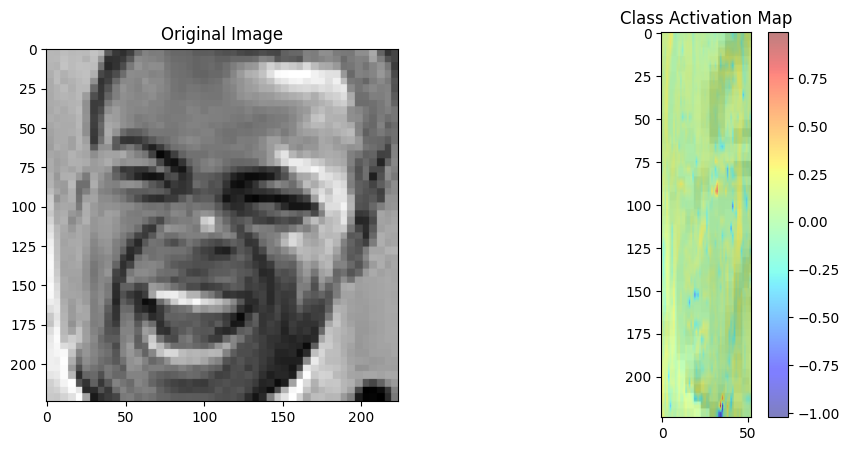

In [22]:
# Get the name of the last convolutional layer
last_conv_layer_name = 'conv2d_2'

# Load a sample image from your test dataset
sample_image_path = 'test/happy/PrivateTest_556985.jpg'
img = image.load_img(sample_image_path, target_size=(224, 224), color_mode='grayscale')
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Define a function to generate CAM
def generate_cam(model, last_conv_layer_name, image_array):
    # Extract the last convolutional layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    
    # Create a new model with the last convolutional layer as output
    cam_model = Model(inputs=model.input, outputs=last_conv_layer.output)
    
    # Get the weights of the output layer
    output_weights = model.layers[-1].get_weights()[0]
    
    # Compute the feature maps
    features = cam_model.predict(image_array)
    
    # Calculate the class activation map
    cam = tf.matmul(features, output_weights)
    cam = tf.reduce_sum(cam, axis=-1)
    
    return cam

# Generate CAM
cam = generate_cam(model, last_conv_layer_name, img_array)

# Normalize CAM
cam /= np.max(cam)

# Resize CAM to the size of the input image
cam = tf.image.resize(cam, (224, 224))

# Convert to numpy array
cam = cam.numpy()[0]

# Display the original image and CAM overlay
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(img, cmap='gray', alpha=0.5)
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.title('Class Activation Map')
plt.colorbar()
plt.savefig('output/cam_image.png')
plt.show()
